# DAT-ATX-1 Capstone Project

#### Nikolaos Vergos, February 2016
<nvergos@gmail.com>


## 1. Data Preparation & Exploratory Analysis

*Disclaimer: Many ideas for the Exploratory Data Analysis part, particularly the discussion of the health inspection scores histogram, the correlation between two different inspections and the plot_restaurant_score_by_type Python function and the discussion of the resulting plots have been taken by the analysis of [Dr. Tal Yarkoni](https://github.com/tyarkoni/open-data-flights/blob/master/health-inspection/flight1.ipynb)*

### 0. Import libraries & packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats # For correlation coefficient calculation

### 1. Familiarize ourselves with our data

In [3]:
#Reading the dataset in a dataframe using Pandas
df = pd.read_csv("Restaurant_Inspection_Scores.csv")  

#Print first observations
df.head() 

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description
0,Corner Store #3958,78754,12/23/2015,100,"12307 DESSAU RD\nAUSTIN, TX 78754\n(30.3872270...",11281491,Routine Inspection
1,Mr. Gatti's #118,78758,12/23/2015,94,"2121 W PARMER LN\nAUSTIN, TX 78758\n(30.415649...",2801996,Routine Inspection
2,Texaco Braker Mart,78758,12/23/2015,83,"2601 W BRAKER LN\nAUSTIN, TX 78758\n(30.390268...",10001712,Routine Inspection
3,Taco Bell,78753,12/23/2015,93,"9504 N LAMAR BLVD\nAUSTIN, TX 78753\n(30.36480...",11066396,Routine Inspection
4,Subway,78758,12/23/2015,98,"2501 W PARMER LN\nAUSTIN, TX 78758\n(30.418236...",10385802,Routine Inspection


In [4]:
len(df)

22879

In [5]:
# Drop duplicate entries
df = df.drop_duplicates()

In [6]:
print "There are {0} entries (rows) in this dataframe".format(len(df)) # Initial assessment

There are 22875 entries (rows) in this dataframe


Almost all column names have spaces between the words. Even though it looks nice on the dataframe, it can actually be quite problematic further down the way. Therefore, let us implement an easy fix that will save us lots of pain later on:

In [7]:
df = df.rename(columns={'Restaurant Name': 'Restaurant_Name', 'Zip Code' : 'Zip_Code',
                        'Inspection Date' : 'Inspection_Date', 'Facility ID' : 'Facility_ID',
                       'Process Description' : 'Process_Description'})

The "Inspection_Date" column looks like a humanly readable series of dates, however it is encoded as (useless) strings. Fortunately we can easily tell pandas to see this column as a *datetime* format for easier and better reference:

In [8]:
from datetime import datetime

df['Inspection_Date'] = pd.to_datetime(df['Inspection_Date'])

Let us also create an auxiliary DataFrame where each establishment shows up once (even though there are 5-6 inspection instances per establishment) - we need to know how many individual establishments are inspected. Side note: I am using the word "establishment" instead of "restaurant", because the Austin/Travis County Health and Human Services Department conducts the permitting and inspection of more than 4,000 food *establishments* in Austin, several local municipalities and rural Travis County. This includes any place serving food: restaurants, school cafeterias, grocery and convenience stores etc. We will deal with this later, because we have chosen to focus our study on restaurants (loosely defined as places that a potential patron chooses to go dine or carry out)

In [9]:
establishments = df.groupby('Facility_ID')

In [10]:
# Print some stuff
print "Number of inspections:", len(df)
print "Number of individual establishments inspected:", len(establishments)
print "\nColumns:\n", df.dtypes

Number of inspections: 22875
Number of individual establishments inspected: 4774

Columns:
Restaurant_Name                object
Zip_Code                        int64
Inspection_Date        datetime64[ns]
Score                           int64
Address                        object
Facility_ID                     int64
Process_Description            object
dtype: object


We have nearly 23,000 inspections from over 4,700 distinct establishments. For each inspection, we have (among other things) a health inspection score, an establishment name, an inspection date, and a description of the process (i.e., whether the inspection was routine, or reflected a follow-up visit triggered by an establishment failing an earlier inspection).

Let us start our exploratory data analysis by a simple frequency table of the health inspection scores:

In [11]:
print df['Score'].value_counts().sort_index() # Frequency Table

36        1
45        1
46        1
48        1
50        3
51        2
53        5
54        1
56        6
57        7
58        6
59       14
60       11
61       10
62        9
63       16
64       14
65       19
66       14
67       12
68       23
69       15
70      125
71      115
72      129
73      140
74      150
75      158
76      175
77      203
78      261
79      228
80      305
81      397
82      419
83      409
84      499
85      618
86      642
87      620
88      701
89      859
90     1137
91      802
92      897
93     1645
94     1438
95      475
96     1274
97     3099
98       76
99       76
100    4612
Name: Score, dtype: int64


The first striking result is that, given the health inspectors are doing their job meticulously, Austin is a quite sanitary city for diners. Recall that a failing score is below 70, and according to the ad hoc letter grade scheme we are going to implement, the vast majority of inspections leeds to a letter grade "A", which we would say symbolizes a "pristine" establishment. We are going to perform some thorough research in the Machine Learning part of this Project, however this dataset can yield some quite interesting visualizations:

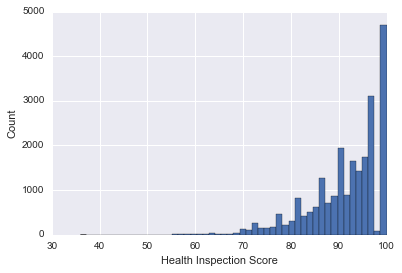

In [12]:
# Function to plot a histogram based on the frequency table above:

def plot_histogram():
    df['Score'].hist(bins=50)
    plt.xlabel('Health Inspection Score')
    plt.ylabel('Count')
    plt.savefig('histogram.png')

plot_histogram()

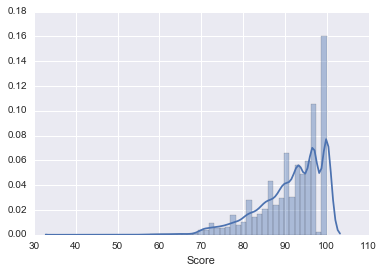

In [13]:
# A somewhat prettier histogram with seaborn; Relative frequencies on y-axis
sns.distplot(df['Score']);

We see that the distribution of our data is **heavily** skewed to the left (i.e. bunched up toward the right with a "tail" stretching toward the left). There are zero health inspection scores of 98 or 99--presumably because the smallest possible violation results in a loss of at least 3 points. A similar explanation probably accounts for the dip around 95 i.e., it's relatively unusual to getting docked exactly 5 points for a single infraction.

More curious, though, is what happens at the low end of the distribution--specifically around a score of 70, where there appears to be a relatively sharp discontinuity. To see it better, we can zoom in:

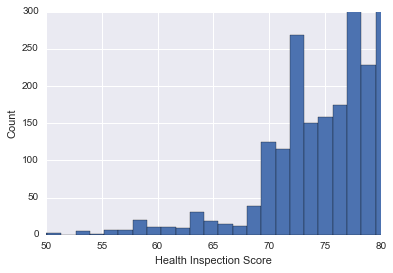

In [14]:
plot_histogram()
plt.xlim([50,80]);
plt.ylim([0,300]);

There is a sharp break at 70. Recall that 70 is the minimum score required to pass inspection. If a restaurant gets a score below that, it fails inspection, which presumably triggers all kinds of unpleasant things - e.g., more paperwork for the inspector, bad PR for the restaurant, and a follow-up (non-routine) inspection one or two weeks later. So one possibility here is that there's some pressure on inspectors - whether explicit or implicit - to avoid giving restaurants failing scores. This could possibly explain the fact that 99% of the entries in our data set have passing scores, as we are going to see later. Unfortunately this great imbalance between passing and failing restaurants will significantly hinder our attempts to build predictive models with confidence.

[Dr. Tal Yarkoni](https://github.com/tyarkoni/open-data-flights/blob/master/health-inspection/flight1.ipynb) offers some more interesting explanations: *For example, it's possible that the health inspection guidelines explicitly allow inspectors to let restaurants off with a warning. Or perhaps the scoring algorithm isn't just a linear sum of all the violations observed, and there has to be some particularly egregious health code violation in order for a restaurant to receive a score below 70. Or, inspectors may be pragmatically working around weaknesses in the code - e.g., a restaurant may theoretically be able to fail inspection because of a large number of minor infractions, even if no single infraction presents any meaningful health risk to customers.*

*Still, absent an explanation, there's at least some potential cause for concern here, and it's certainly consistent with the data that health inspectors might be systematically grading restaurants more leniently than they should be. Are the inspectors doing their job meticulously? Is Austin dining really so sanitary overall?*

This is a recurring theme of this study, as we are going to see.

### 2. Data Preparation

On to the immensely boring, yet quintessential part: data cleaning. I will start by renaming some of our restaurants so they'll avoid the axe when I remove everything which isn't a restaurant - as I have mentioned, unfortunately the data set includes every establishment that needs a health inspection, and I'm only interested in places where people actually choose to dine in, not schools, churches, jails (!) etc...

In [15]:
# Unfortunately the words "Market", "Grocery", "Church" correspond to places
# like convenience stores and grocery stores.

# I want to make sure that some restaurants with those words in their name will go through my filter.

df.loc[(df['Restaurant_Name'].str.contains('Whole')) , 'Restaurant_Name'] = "Whole Foods"
df.loc[(df['Restaurant_Name'].str.contains('Central Market')) , 'Restaurant_Name'] = "Central Mkt"
df.loc[(df['Restaurant_Name'].str.contains('Boston Market')) , 'Restaurant_Name'] = "Boston Mkt"
df.loc[(df['Restaurant_Name'].str.contains('Mandola')) , 'Restaurant_Name'] = "Mandola's"
df.loc[(df['Restaurant_Name'].str.contains('Royal Blue')) , 'Restaurant_Name'] = "Royal Blue"
df.loc[(df['Restaurant_Name'].str.contains('Rudy')) , 'Restaurant_Name'] = "Rudy's"
df.loc[(df['Restaurant_Name'].str.contains('Fit Foods')) , 'Restaurant_Name'] = "My Ft Foods"
df.loc[(df['Restaurant_Name'].str.contains("Church's Chicken")) , 'Restaurant_Name'] = "Chrch Chicken"
df.loc[(df['Restaurant_Name'].str.contains("Schlotzsky's")) , 'Restaurant_Name'] = "Schlotzsky's"

In [16]:
len(df)

22875

Let me now filter out everything that doesn't follow my loose definition of a restaurant:

In [17]:
df = df[df['Restaurant_Name'].str.contains('School') == False]
df = df[df['Restaurant_Name'].str.contains('Elementary') == False]
df = df[df['Restaurant_Name'].str.contains('Care') == False]
df = df[df['Restaurant_Name'].str.contains('Middle') == False]
df = df[df['Restaurant_Name'].str.contains('Cafeteria') == False]
df = df[df['Restaurant_Name'].str.contains('Jail') == False]
df = df[df['Restaurant_Name'].str.contains('ISD') == False]
df = df[df['Restaurant_Name'].str.contains('Academy') == False]

df = df[df['Restaurant_Name'].str.contains('Mart') == False]
df = df[df['Restaurant_Name'].str.contains('Gas') == False]
df = df[df['Restaurant_Name'].str.contains('Convenience') == False]
df = df[df['Restaurant_Name'].str.contains('7-Eleven') == False]
df = df[df['Restaurant_Name'].str.contains('HEB') == False]
df = df[df['Restaurant_Name'].str.contains('Station') == False]
df = df[df['Restaurant_Name'].str.contains('Randall') == False]
df = df[df['Restaurant_Name'].str.contains('Target') == False]
df = df[df['Restaurant_Name'].str.contains('Flea') == False]

df = df[df['Restaurant_Name'].str.contains('Gym') == False]
df = df[df['Restaurant_Name'].str.contains('Fitness') == False]
df = df[df['Restaurant_Name'].str.contains('Fit') == False]

df = df[df['Restaurant_Name'].str.contains('Church') == False]
df = df[df['Restaurant_Name'].str.contains('Dollar') == False]
df = df[df['Restaurant_Name'].str.contains('Store') == False]
df = df[df['Restaurant_Name'].str.contains('Texaco') == False]

In [18]:
print len(df)

18292


In [20]:
restaurants = df.groupby('Facility_ID') # We can switch from "establishments" to "restaurants" after the purge
len(restaurants)

3934

We got rid of 4583 DataFrame rows corresponding to inspections of 840 establishments. Not bad at all!

### 3. Data Exploration & Visualizations

An important question is whether scores are stable over time within individual restaurants. Since the vast majority of restaurants have been inspected several times (mostly twice a year) over the last three years, we can directly answer this question by computing the test-retest Pearson correlation metric across multiple inspections.

A quick, though somewhat crude, way to do this is to randomly select two inspections for every restaurant with multiple inspections and compute the correlation. The resulting scatter plot looks like this:

Number of restaurants with two or more inspections: 3682


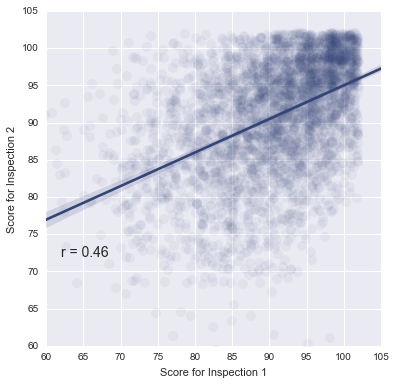

In [22]:
# Cite: Analysis by Dr. Tal Yarkoni

# Filter for restaurants with > 1 inspection

two_or_more = restaurants.filter(lambda x: x.shape[0] > 1)
print "Number of restaurants with two or more inspections:", two_or_more['Facility_ID'].nunique()


# Shuffle order and select a random pair for each restaurant

two_or_more = two_or_more.reindex(np.random.permutation(two_or_more.index))
random_pairs = two_or_more.groupby('Facility_ID', as_index=False).head(2).sort('Facility_ID')
random_pairs['number'] = np.tile(np.array([1,2]), len(random_pairs)/2)
pairs = random_pairs.pivot(index='Facility_ID', columns='number', values='Score')
r, p = stats.pearsonr(*pairs.values.T)

# Plot the relationship

f, ax = plt.subplots(figsize=(6, 6))
sns.regplot(pairs[1], pairs[2], x_jitter=2, y_jitter=2,
            color="#334477", scatter_kws={"alpha": .05, "s":100})

ax.text(62, 72, "r = %.2f" % r, fontsize=14)
ax.set(xlim=(60, 105), ylim=(60, 105),
        xlabel='Score for Inspection 1',
        ylabel='Score for Inspection 2');

The test-retest correlation of **0.46** indicates that there is indeed a fair amount of consistency to the scores. 

That's reassuring, in that a very low correlation might lead us to worry that the health inspection process itself is unreliable, since it's hard to imagine that there aren't real differences in how mindful different proprietors are of health code - not to mention the fact that some kinds of establishments are likely to be at much higher risk of code violations than others in virtue of the kind of food they serve.

In simpler words, if a restaurant does well, it will probably keep doing well. If it barely passes inspection one time, it probably won't improve dramatically for the second time. However, there's a quite interesting phenomenon at the "outliers" of the scatterplot above: There seem to be some restaurants that have obtained "pristine" scores during inspection 1 and then dropped by 20 points or more during inspection 2 and vice versa. The vast majority of establishments show a fair grade of consistency though.



The following part could have been much easier and much more exciting, had the City of Austin provided us with a richer dataset including some extra columns with information such as type of cuisine or some classification of infestations that have caused point deductions. A significantly richer analysis would have been possible in that case.

We can still implement an ad hoc workaround to break out restaurants by the kind of food they serve, provided their names are indicative of the cuisine. we're going to categorize restaurant type much more crudely. We'll take advantage of the fact that many restaurants use their name to announce the kind of food they serve - witness, for example, "Carino's Italian", "Asia Chinese Restaurant", and "Mi Casa Mexican Restaurant". Dr. Yarkoni did an amazing job:

By grouping together restaurants with the same stem of a word in their names, we can generate the following plot:

In [23]:
# Create unique ID column that's human-readable--concatenate name and address

df['string_id'] = [x.lower() for x in (df['Restaurant_Name'] + '_' + df['Facility_ID'].astype(str))]

In [25]:
def plot_restaurant_score_by_type(types):
    """ Takes a list of strings, each defining a group of restaurants that contain that 
    particular string within their title. """
    
    means, sems, labels = [], [], []
    n_types = len(types)
    
    # Generate means, CI/SEM, and labels
    for c in types:
        stores = df[df['string_id'].str.contains(c)]
        unique_stores = stores.groupby('string_id')['Score'].mean()
        n_stores = len(unique_stores)
        n_inspections = len(stores)
        std = unique_stores.std()
        means.append(unique_stores.mean())
        sems.append(stats.sem(unique_stores)) # sem: standard error of the mean
        labels.append('"' + c + '" (%d, %d)' % (n_stores, n_inspections))
    
    # Order by descending score
    plot_data = pd.DataFrame({'mean':means, 'sem':sems}, index=labels)
    plot_data = plot_data.sort('mean', ascending=True)

    # Plot
    pal = sns.color_palette("husl", len(plot_data))
    f, ax = plt.subplots(figsize=(4, 8))
    for y, (label, (mean, sem)) in enumerate(plot_data.iterrows()):
        ax.errorbar(mean, y, xerr=sem, fmt='o', color=pal[y])
    ax.set_ylim([-1, n_types])
    ax.set_yticks(np.arange(len(plot_data)))
    ax.set_yticklabels(plot_data.index, rotation=0, horizontalalignment='right')
    ax.set_xlabel('Health inspection score', fontsize=14)
    ax.set_ylabel('Restaurant name contains...', fontsize=14)
    
types = ['chin', 'mexic', 'indian', 'thai', 'vietnam|pho', 'italia', 'taco|taqu', 'sushi|jap', 
         'pizz', 'korea', 'burger', 'donut|doughnut', 'coffee', 'bakery', 'ice cream', 
         'chicken', 'buffet', 'grill', 'bbq|barbe', 'steak', 'greek', 'beer']

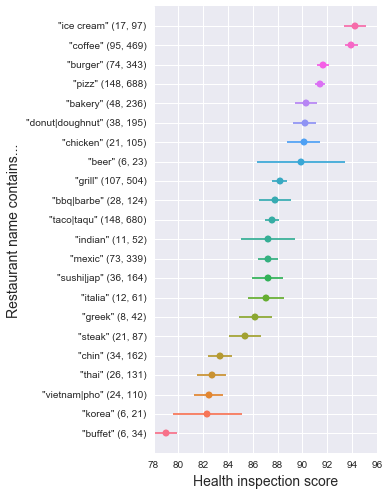

In [26]:
plot_restaurant_score_by_type(types)

The values in parentheses on the y-axis labels denote the number of unique restaurants and total inspections in each group, respectively. The error bars denote the 95% confidence interval.

The plot largely corroborates what we probably already knew, with perhaps a couple of minor surprises. It's not surprising that establishments primarily serving coffee, ice cream, or pastries tend to do very well on health inspections. The same applies for most burger and pizza places, and I believe this has to do with strict health protocols universally implemented by national chains that seem to dominate those categories. As we will see with the next plot, restaurants belonging to major chains tend to do exceptionally well in health inspections with very little variance.

At the other end of the spectrum, the 6 restaurants with the word "buffet" in their name do quite... abysmally. Their average score of 79 is pretty close to the magical failure number of 70. Across 34 different inspections, no "buffet"-containing restaurant in Austin has managed to obtain a score higher than 90 in the past 3 years. Of course, this conclusion only applies to buffet restaurants that have the word "buffet" in their name, but I believe those comprise the vast majority of all-you-can-eat type eateries, even though I hope I am wrong, because to be honest sometimes buffets can be quite yummy...

Also not happy winners in this analysis: restaurants serving ethnic food - with the possible exception of Indian restaurants (though the variance for Indian restaurants is high. Asian restaurants do particularly poorly; for example, "thai"-containing restaurants obtain a score of 83, on average.

It seems that every restaurant following the "bbq" category could be classfied as "ethnic" and this leads to an interesting question, which we cannot really answer given the data we have: **Are ethnic restaurants bound to be doing worse than their "american" counterparts, or is there some kind of inspector bias against "different" cuisines?** Of course diners can form their individual opinions freely and I do not wish to nudge the discussion toward either side, however this trend is really striking to me.

*On a positive note, though, we can see that the 74 "burger"-containing establishments in this list - you know, the ones where cooks spend much of their day wading around in buckets of raw meat--tend to have very good scores (perhaps because of the perception that health inspectors are gunning for them, I don't know). So, given a choice between Thai food and burger, health code-wise, you're arguably better off with burger. Of course, in the grand scheme of things, these are not terribly large differences, and the vast majority of the time, you're going to be just fine after eating pretty much anywhere (including even those restaurants that fail inspection).*

Various discussions with colleagues have lead me to the result that this is most probably happening because national chains can't and won't tolerate PR scandals associated with the sanitary qualities of their food, therefore their protocols concerning food preparations are quite strict, as I have mentioned above. 

##### Let's eat clean tonight! - Pizza Hut, right???



Since it's easy to bin restaurants by title, something else we can do is look at the performance of major local and national food chains. Here's what that looks like, for selected chains with major representation in Austin:

In [27]:
chains = ['starbucks', 'mcdonald', 'subway', 'popeye', 'whataburger', 'domino', 
         'jamba', 'schlotzsky', 'taco shack', 'burger king', 'wendy', 
         'panda', 'chick-fil', 'pizza hut', 'papa john', 'chipotle', 'pei wei', 'torchy', 'tacodeli']

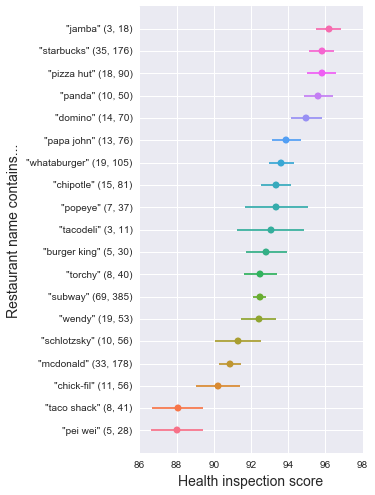

In [28]:
plot_restaurant_score_by_type(chains)

Good news! It's pretty much impossible to get sick at Jamba Juice or Starbucks. The large pizza chains all do very well. Also, if you're looking for health code-friendly Asian food, Panda Express is your new best friend. If your primary basis for deciding between drive-thrus is tiny differences in health inspection score, you may want to opt for local hero Whataburger, Wendy's or Burger King over McDonald's. Otherwise, there's nothing terribly interesting here, other than the suprisingly low (for me) scores of Pei Wei, which I have to admit I used to hold in a higher esteem. An average score of 88 of course isn't something to be very disappointed about, but it seems that they, being a national chain, are slightly more lax when it comes to their food preparation protocols compared to their more "fast-food" counterpart, Panda Express.

The reader is strongly encouraged to visit [Tal Yarkoni's notebook](https://github.com/tyarkoni/open-data-flights/blob/master/health-inspection/flight1.ipynb) for further exploratory data analysis on the Ceity of Austin Restaurant Health Inspection dataset.

### 4. Enriching our dataset by adding numerics

As we have seen, our only quantitative variable in our data set is each restaurant's score. Even though the given data set can lead us to a fairly thorough exploration and raise some quite interesting questions, as we have seen so far, my opinion is that our output would be much richer if we had more information. The steps I took to address this are:

- I unilaterally decided to trim down the area of interest. Health Inspections are conducted by Travis County which is rather spacious and includes the City of Austin, the neighboring communities like Pflugerville as well as some far-flung suburbs like Lago Vista or Manor. I spent some time over a map and ended up deciding to focus my analysis from now on in my loose definition of the **Austin City Limits**. Roughly this translates as eliminating all rows from my DataFrames that belong to the suburban Zip Codes.


- I did some more research on the remaining 36 Zip Codes after the purge above, and following U.S. Census Data from 2014 I incorporated three more columns into my DataFrame: Population, Median Income and Home Ownership percentage for each one of the Austin City Limits Zip Codes.

In [29]:
# Let's see how many Zip Codes do we start with:

print len(pd.unique(df.Zip_Code.ravel()))

56


Those 56 Zip Codes cover the entire area of Travis County where the Austin/Travis County Health and Human Services Department conducts the inspections. After spending some time studying a detailed map, I decided to only keep a subset of those 56 Zip Codes from now on, even though this means I am trimming down my data set. I am interested in Austin proper:

In [30]:
# Focus on the main part of the city
# The geographical division is mine

SE_zip = (78744, 78747, 78719, 78741)
Central_zip = (78701, 78702, 78703, 78705, 78721, 78723, 78712, 78751, 78756)
NE_zip = (78752, 78753, 78754)
NW_zip = (78757, 78758, 78727, 78722, 78729, 78717, 78750, 78759, 78726, 78730, 78731, 78732)
SW_zip = (78704, 78745, 78748, 78739, 78749, 78735, 78733, 78746)

ACL_zip = SE_zip + Central_zip + NE_zip + NW_zip + SW_zip
len(ACL_zip)

36

36 Zip Codes of a more or less contiguous area is what we will be focusing on from now on.

In [31]:
# Create a new DataFrame only including Austin City Limits restaurants:

ACL = df[df.Zip_Code.isin(ACL_zip)]
ACL.describe()

,Zip_Code,Score,Facility_ID
count,16113.000000,16113.000000,16113.000000
mean,78732.831565,90.556383,7290115.054118
std,21.670047,8.003905,3846991.045580
min,78701.000000,36.000000,2800004.000000
25%,78705.000000,86.000000,2801979.000000
50%,78741.000000,92.000000,10091552.000000
75%,78752.000000,97.000000,10662646.000000
max,78759.000000,100.000000,11386831.000000


Let us now introduce the U.S. 2014 Census numerics data: 

In [32]:
raw_data = {
        'Zip_Code': [78701, 78702, 78703, 78705, 78721, 78723, 78712, 78751, 78756, 78744, 78747, 78719, 78741,\
                    78752, 78753, 78754, 78704, 78745, 78748, 78739, 78749, 78735, 78733, 78746, 78757, 78758,\
                    78727, 78722, 78729, 78717, 78750, 78759, 78726, 78730, 78731, 78732],
        'Med_Income': [35757, 23348, 54591, 14740, 26646, 34242, np.nan, 29779, 36978, 38256, 60861, np.nan, 25369,\
                      30207, 38206, 51810, 35733, 43458, 57710, 102707, 68244, 75204, 102239, 100571,\
                      45090, 42398, 62648, 35794, 59497, 87290, 78428, 61284, 89891, 128524, 62404, 103951],
        'Population': [3780, 22498, 19522, 26972, 10192, 30196, np.nan, 13829, 7253, 34028, 4908, np.nan, 40678,\
                      17978, 43788, 5517, 43343, 53136, 25138, 8708, 28420, 9563, 9144, 25768,\
                      21434, 42977, 22332, 6264, 24539, 8209, 23563, 40327, 6547, 4848, 24068, 3804],
        'Home_Ownership': [0.377, 0.467, 0.515, 0.11, 0.576, 0.441, np.nan, 0.259, 0.395, 0.536, 0.89, np.nan, 0.146,\
                          0.266, 0.407, 0.11, 0.302, 0.09, 0.739, 0.962, 0.36, 0.564, 0.901, 0.71,\
                          0.566, 0.309, 0.573, 0.468, 0.516, 0.793, 0.717, 0.451, 0.7, 0.74, 0.593, 0.97]}

df_numerics = pd.DataFrame(raw_data, columns = ['Zip_Code','Med_Income', 'Population', 'Home_Ownership'])
df_numerics

,Zip_Code,Med_Income,Population,Home_Ownership
0,78701,35757,3780,0.377
1,78702,23348,22498,0.467
2,78703,54591,19522,0.515
3,78705,14740,26972,0.110
4,78721,26646,10192,0.576
5,78723,34242,30196,0.441
6,78712,NaN,NaN,NaN
7,78751,29779,13829,0.259
8,78756,36978,7253,0.395
9,78744,38256,34028,0.536


78712 is the special Zip Code for the University of Texas Campus and 78719 corresponds to Austin - Bergstrom International Airport.

Let us now merge the two DataFrames, ACL and df_numerics into a common one:

In [33]:
merged = pd.merge(ACL, df_numerics, on='Zip_Code')
merged.head()

,Restaurant_Name,Zip_Code,Inspection_Date,Score,Address,Facility_ID,Process_Description,string_id,Med_Income,Population,Home_Ownership
0,Mr. Gatti's #118,78758,2015-12-23,94,"2121 W PARMER LN\nAUSTIN, TX 78758\n(30.415649...",2801996,Routine Inspection,mr. gatti's #118_2801996,42398,42977,0.309
1,Subway,78758,2015-12-23,98,"2501 W PARMER LN\nAUSTIN, TX 78758\n(30.418236...",10385802,Routine Inspection,subway_10385802,42398,42977,0.309
2,Baskin Robbins,78758,2015-12-23,99,"12407 N MOPAC EXPY\nAUSTIN, TX 78758\n(30.4174...",2802274,Routine Inspection,baskin robbins_2802274,42398,42977,0.309
3,JR's Tacos,78758,2015-12-22,91,"1921 CEDAR BEND DR\nAUSTIN, TX 78758\n(30.4083...",10964220,Routine Inspection,jr's tacos_10964220,42398,42977,0.309
4,Econo Lodge,78758,2015-12-22,91,"9100 BURNET RD\nAUSTIN, TX 78758\n(30.37479048...",10778546,Routine Inspection,econo lodge_10778546,42398,42977,0.309


### 5. DataFrame TLC and a very interesting visualization

Our "main" DataFrame needs some TLC. We also have to exploit the "Address" column further by creating neat columns with street address, city information and coordinates for each row - even though we are focusing in the contiguous Austin area, we are still having the areas of Rollingwood, West Lake Hills, Sunset Valley and Bee Cave to take into account (and get some interesting associations between Restaurant Health Inspection Score and Income...)

In [34]:
# Creation of a DataFrame off of the constituent components of the 'Address' Column:

merged_location = merged['Address'].apply(lambda x: pd.Series(x.split('\n')))

In [35]:
merged_location.head()

,0,1,2
0,2121 W PARMER LN,"AUSTIN, TX 78758","(30.4156492668216, -97.6975693977174)"
1,2501 W PARMER LN,"AUSTIN, TX 78758","(30.4182363972979, -97.7022420545932)"
2,12407 N MOPAC EXPY,"AUSTIN, TX 78758","(30.4174621728585, -97.7028442208035)"
3,1921 CEDAR BEND DR,"AUSTIN, TX 78758","(30.408322328997, -97.6982433226702)"
4,9100 BURNET RD,"AUSTIN, TX 78758","(30.3747904817031, -97.7264170496741)"


Let's reformat the first two columns for geocoding:

In [36]:
geocode = merged_location[0] + ', ' + merged_location[1]

In [37]:
geocode.head()

0      2121 W PARMER LN, AUSTIN, TX 78758
1      2501 W PARMER LN, AUSTIN, TX 78758
2    12407 N MOPAC EXPY, AUSTIN, TX 78758
3    1921 CEDAR BEND DR, AUSTIN, TX 78758
4        9100 BURNET RD, AUSTIN, TX 78758
dtype: object

In [40]:
# What about the coordinates column?

merged_location[2].head(2)

0    (30.4156492668216, -97.6975693977174)
1    (30.4182363972979, -97.7022420545932)
Name: 2, dtype: object

Each element of column [2] of the merged_location DataFrame is a parenthesis with a pair of coordinates inside it, representing latitude and longitude. Those seem like an interesting addition to our dataframe, therefore we'll do a little bit more work to add them as individual columns:

In [41]:
# Get rid of the parentheses:

coords = pd.Series(merged_location[2])

stripped_coords = []
for coord in coords:
    coord = coord.strip('()')
    stripped_coords.append(coord)

In [42]:
stripped_coords[1]

'30.4182363972979, -97.7022420545932'

In [43]:
merged['Coordinates'] = pd.Series(stripped_coords)

In [44]:
merged['Latitude'] = 0
merged['Longitude'] = 0

Following Chris Albon's excellent [code snippet](http://chrisalbon.com/python/geocoding_and_reverse_geocoding.html):

In [45]:
# Create two lists for the loop results to be placed
lat = []
lon = []

# For each row in a varible,
for row in merged['Coordinates']:
    # Try to,
    try:
        # Split the row by comma, convert to float, and append
        # everything before the comma to lat
        lat.append(float(row.split(',')[0]))
        # Split the row by comma, convert to float, and append
        # everything after the comma to lon
        lon.append(float(row.split(',')[1]))
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
merged['Latitude'] = lat
merged['Longitude'] = lon

In [46]:
merged.head()

,Restaurant_Name,Zip_Code,Inspection_Date,Score,Address,Facility_ID,Process_Description,string_id,Med_Income,Population,Home_Ownership,Coordinates,Latitude,Longitude
0,Mr. Gatti's #118,78758,2015-12-23,94,"2121 W PARMER LN\nAUSTIN, TX 78758\n(30.415649...",2801996,Routine Inspection,mr. gatti's #118_2801996,42398,42977,0.309,"30.4156492668216, -97.6975693977174",30.415649,-97.697569
1,Subway,78758,2015-12-23,98,"2501 W PARMER LN\nAUSTIN, TX 78758\n(30.418236...",10385802,Routine Inspection,subway_10385802,42398,42977,0.309,"30.4182363972979, -97.7022420545932",30.418236,-97.702242
2,Baskin Robbins,78758,2015-12-23,99,"12407 N MOPAC EXPY\nAUSTIN, TX 78758\n(30.4174...",2802274,Routine Inspection,baskin robbins_2802274,42398,42977,0.309,"30.4174621728585, -97.7028442208035",30.417462,-97.702844
3,JR's Tacos,78758,2015-12-22,91,"1921 CEDAR BEND DR\nAUSTIN, TX 78758\n(30.4083...",10964220,Routine Inspection,jr's tacos_10964220,42398,42977,0.309,"30.408322328997, -97.6982433226702",30.408322,-97.698243
4,Econo Lodge,78758,2015-12-22,91,"9100 BURNET RD\nAUSTIN, TX 78758\n(30.37479048...",10778546,Routine Inspection,econo lodge_10778546,42398,42977,0.309,"30.3747904817031, -97.7264170496741",30.374790,-97.726417


In [47]:
# Create a DataFrame off of column [1] of merged_location: City and State-Zip Code:

cities = merged_location[1].apply(lambda x: pd.Series(x.split(',')))

In [48]:
cities.head()

,0,1
0,AUSTIN,TX 78758
1,AUSTIN,TX 78758
2,AUSTIN,TX 78758
3,AUSTIN,TX 78758
4,AUSTIN,TX 78758


In [49]:
# How many are the unique cities in our DataFrame?

pd.unique(cities[0].ravel())

array(['AUSTIN', 'ROLLINGWOOD', 'WEST LAKE HILLS', 'SUNSET VALLEY',
       'BEE CAVE'], dtype=object)

In [50]:
# All our restaurants are in Texas, and we have already dealt with Zip Codes. Ergo we don't need column [1]:

del cities[1]

In [51]:
cities.head()

,0
0,AUSTIN
1,AUSTIN
2,AUSTIN
3,AUSTIN
4,AUSTIN


In [52]:
# Let us add this neatly divided information into our main DataFrame:

merged['Street'] = merged_location[0]
merged['City'] = cities[0]
merged['Geocode'] = geocode

In [53]:
merged.head(10)

,Restaurant_Name,Zip_Code,Inspection_Date,Score,Address,Facility_ID,Process_Description,string_id,Med_Income,Population,Home_Ownership,Coordinates,Latitude,Longitude,Street,City,Geocode
0,Mr. Gatti's #118,78758,2015-12-23,94,"2121 W PARMER LN\nAUSTIN, TX 78758\n(30.415649...",2801996,Routine Inspection,mr. gatti's #118_2801996,42398,42977,0.309,"30.4156492668216, -97.6975693977174",30.415649,-97.697569,2121 W PARMER LN,AUSTIN,"2121 W PARMER LN, AUSTIN, TX 78758"
1,Subway,78758,2015-12-23,98,"2501 W PARMER LN\nAUSTIN, TX 78758\n(30.418236...",10385802,Routine Inspection,subway_10385802,42398,42977,0.309,"30.4182363972979, -97.7022420545932",30.418236,-97.702242,2501 W PARMER LN,AUSTIN,"2501 W PARMER LN, AUSTIN, TX 78758"
2,Baskin Robbins,78758,2015-12-23,99,"12407 N MOPAC EXPY\nAUSTIN, TX 78758\n(30.4174...",2802274,Routine Inspection,baskin robbins_2802274,42398,42977,0.309,"30.4174621728585, -97.7028442208035",30.417462,-97.702844,12407 N MOPAC EXPY,AUSTIN,"12407 N MOPAC EXPY, AUSTIN, TX 78758"
3,JR's Tacos,78758,2015-12-22,91,"1921 CEDAR BEND DR\nAUSTIN, TX 78758\n(30.4083...",10964220,Routine Inspection,jr's tacos_10964220,42398,42977,0.309,"30.408322328997, -97.6982433226702",30.408322,-97.698243,1921 CEDAR BEND DR,AUSTIN,"1921 CEDAR BEND DR, AUSTIN, TX 78758"
4,Econo Lodge,78758,2015-12-22,91,"9100 BURNET RD\nAUSTIN, TX 78758\n(30.37479048...",10778546,Routine Inspection,econo lodge_10778546,42398,42977,0.309,"30.3747904817031, -97.7264170496741",30.374790,-97.726417,9100 BURNET RD,AUSTIN,"9100 BURNET RD, AUSTIN, TX 78758"
5,Shahi Food Market,78758,2015-12-22,80,"12410 N LAMAR BLVD\nAUSTIN, TX 78758\n(30.4066...",2803821,Routine Inspection,shahi food market_2803821,42398,42977,0.309,"30.4066900253572, -97.6788692603716",30.406690,-97.678869,12410 N LAMAR BLVD,AUSTIN,"12410 N LAMAR BLVD, AUSTIN, TX 78758"
6,K1 Speed,78758,2015-12-22,87,"2500 MC HALE CT\nAUSTIN, TX 78758\n(30.3851472...",10771103,Routine Inspection,k1 speed_10771103,42398,42977,0.309,"30.3851472596582, -97.7212246080011",30.385147,-97.721225,2500 MC HALE CT,AUSTIN,"2500 MC HALE CT, AUSTIN, TX 78758"
7,Jasper's,78758,2015-12-22,83,"11506 CENTURY OAKS TER\nAUSTIN, TX 78758\n(30....",10006802,Routine Inspection,jasper's_10006802,42398,42977,0.309,"30.4025739974381, -97.7258935626451",30.402574,-97.725894,11506 CENTURY OAKS TER,AUSTIN,"11506 CENTURY OAKS TER, AUSTIN, TX 78758"
8,Papa John's Pizza #930,78758,2015-12-22,84,"1925 RUTLAND DR\nAUSTIN, TX 78758\n(30.3788756...",2800815,Routine Inspection,papa john's pizza #930_2800815,42398,42977,0.309,"30.3788756448479, -97.7130952607857",30.378876,-97.713095,1925 RUTLAND DR,AUSTIN,"1925 RUTLAND DR, AUSTIN, TX 78758"
9,Subway #43067,78758,2015-12-21,96,"1910 W BRAKER LN\nAUSTIN, TX 78758\n(30.392307...",10091620,Routine Inspection,subway #43067_10091620,42398,42977,0.309,"30.3923075644652, -97.7066994048772",30.392308,-97.706699,1910 W BRAKER LN,AUSTIN,"1910 W BRAKER LN, AUSTIN, TX 78758"


In [55]:
# How many kinds of inspections are there?

pd.unique(merged['Process_Description'].ravel())

array(['Routine Inspection', '1st Follow Up to Routine of 50 - 69',
       '2nd Follow Up to 50 - 69', '1st Follow Up to Routine of 49 or less'], dtype=object)

In [56]:
# Delete all columns we don't need anymore:

del merged['Address']
del merged['Coordinates']
del merged['string_id']


In [57]:
# Rearrange remaining columns in a nice way:

merged = merged[['Facility_ID', 'Restaurant_Name', 'Inspection_Date',\
                 'Process_Description', 'Geocode', 'Street', 'City', 'Zip_Code', \
                 'Score', 'Med_Income', 'Population', 'Home_Ownership', 'Latitude', 'Longitude']]

merged.head(3)

,Facility_ID,Restaurant_Name,Inspection_Date,Process_Description,Geocode,Street,City,Zip_Code,Score,Med_Income,Population,Home_Ownership,Latitude,Longitude
0,2801996,Mr. Gatti's #118,2015-12-23,Routine Inspection,"2121 W PARMER LN, AUSTIN, TX 78758",2121 W PARMER LN,AUSTIN,78758,94,42398,42977,0.309,30.415649,-97.697569
1,10385802,Subway,2015-12-23,Routine Inspection,"2501 W PARMER LN, AUSTIN, TX 78758",2501 W PARMER LN,AUSTIN,78758,98,42398,42977,0.309,30.418236,-97.702242
2,2802274,Baskin Robbins,2015-12-23,Routine Inspection,"12407 N MOPAC EXPY, AUSTIN, TX 78758",12407 N MOPAC EXPY,AUSTIN,78758,99,42398,42977,0.309,30.417462,-97.702844


In [59]:
# We have 16113 rows with neat addresses which we will use for mapping

len(merged['Geocode'])

16113

Finally, the interesting visualization I promised. Even though this will be studied in more detail in the next "chapter" of this project, supervised learning, I was wondering whether there is any stark correlation between a restaurant's health inspection score (*response*) and each one of the numerics columns I have added to our data: Median Income, Population and Home Ownership percentage (*features*) 

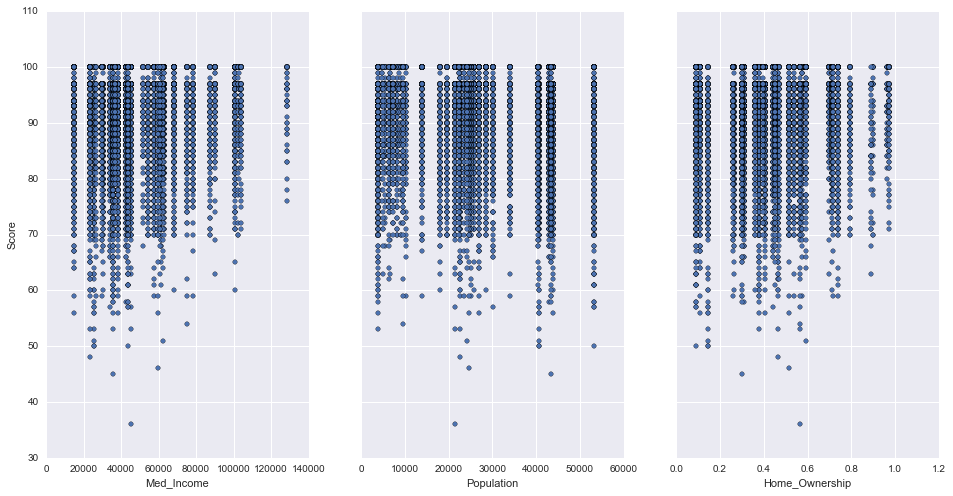

In [60]:
# Visualize the relationship between the features and the response using scatterplots

fig, axs = plt.subplots(1, 3, sharey=True)

merged.plot(kind='scatter', x='Med_Income', y='Score', ax=axs[0], figsize=(16, 8));
merged.plot(kind='scatter', x='Population', y='Score', ax=axs[1]);
merged.plot(kind='scatter', x='Home_Ownership', y='Score', ax=axs[2]);



At first sight the data looks scattered all over the place for all three plots, and there's possibly no correlation between any of the pairs. However there are some interesting remarks one could make:

- As we have already seen, the vast majority of restaurants scores over 70 (passing grade)
- In areas (Zip Codes) where the median income is relatively lower, it is more probable that there will be restaurants doing worse than average. Notice that when the median income is higher than \$120,000, there is not a single restaurant failing the inspection. However this might just be a random fluctuation of our data, since there are a few failing restaurants in areas where the median income lies between \$80,000 and \$120,000
- Population really doesn't seem to play any role; There is a more or less even distribution of health inspection grades irrespective of the Zip Code's population: both the sparsely and the densely populated areas of town have their share of passing and failing restaurants.
- The scatterplot of restaurant health inspection scores vs. percentage of home ownership looks very similar to the one of scores vs median income. We can easily check whether the two quantities are correlated, which we intuitively expect. 

### Next: Supervised Learning - Regression Analysis

Let us save our working DataFrame as a csv file so we can import it into the next Notebook.

In [61]:
merged.to_csv('master.csv', index=False)

We are also going to take a slight detour to the Jupyter Notebook **1a. Mapping Austin Restaurant Scores** where we are going to get our feet wet with geocoding and mapping. Therefore we will need the DataFrame we have been working on so far to be portable to a different notebook.